
**Install requirements**

In [0]:
# !pip3 install 'torch==1.3.1'
# !pip3 install 'torchvision==0.5.0'
# !pip3 install 'Pillow-SIMD'
# !pip3 install 'tqdm'

!rm -rf "./DANN"

**Import libraries**

In [0]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import alexnet
from torchvision.datasets import ImageFolder

from PIL import Image
from tqdm import tqdm

import numpy as np
from google.colab import output

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


**Set Arguments, Define Data Preprocessing, Prepare Datasets, DataLoader and Network**

In [21]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 7 
NUM_DOMAINS = 2

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-3            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 30      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 20       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

IMAGE_SIZE = 224

# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizes tensor with mean and standard deviation
])

# Define transforms for the test phase
test_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                                    
])

# Clone github repository with data
if not os.path.isdir('./PACS'):
  !git clone https://github.com/MachineLearning2020/Homework3-PACS.git
  !mv 'Homework3-PACS' 'PACS'

DATA_DIR = [
  "PACS/PACS/art_painting",
  "PACS/PACS/cartoon",
  "PACS/PACS/photo",
  "PACS/PACS/sketch"
]

train_dataset = ImageFolder(DATA_DIR[2], transform = train_transform) # Photo
test_dataset = ImageFolder(DATA_DIR[0], transform = test_transform) # Art Painting

cartoonDataset = ImageFolder(DATA_DIR[1])
sketchDataset = ImageFolder(DATA_DIR[3])

# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
dataloader_source = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
dataloader_target = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

if not os.path.isdir('./DANN'):
  !git clone https://github.com/cpeluso/HW3-Deep-Domain-Adaptation.git
  !mv 'HW3-Deep-Domain-Adaptation' 'DANN'

from DANN.DANN import RandomNetworkWithReverseGrad

dann = RandomNetworkWithReverseGrad.alexnet_dann(pretrained=True)

for classifier_layer, dann_classifier_layer in zip(dann.classifier, dann.dann_classifier):
  if type(classifier_layer) is torch.nn.modules.linear.Linear:
    dann_classifier_layer.weight.data = classifier_layer.weight.data
    dann_classifier_layer.bias.data = classifier_layer.bias.data

dann.classifier[6] = nn.Linear(4096, NUM_CLASSES)
dann.dann_classifier[6] = nn.Linear(4096, NUM_DOMAINS)

output.clear()

dann

RandomNetworkWithReverseGrad(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_featur

**Prepare Training**

In [0]:
# Define loss function
loss_classifier = nn.CrossEntropyLoss() # for classification, we use Cross Entropy
loss_discriminator = nn.CrossEntropyLoss()

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = dann.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

target_set = iter(dataloader_target)

def sample_target(step, n_batches):
    global target_set
    if step % n_batches == 0:
        target_set = iter(dataloader_target)
    return target_set.next()

**Train**

<Figure size 432x288 with 0 Axes>

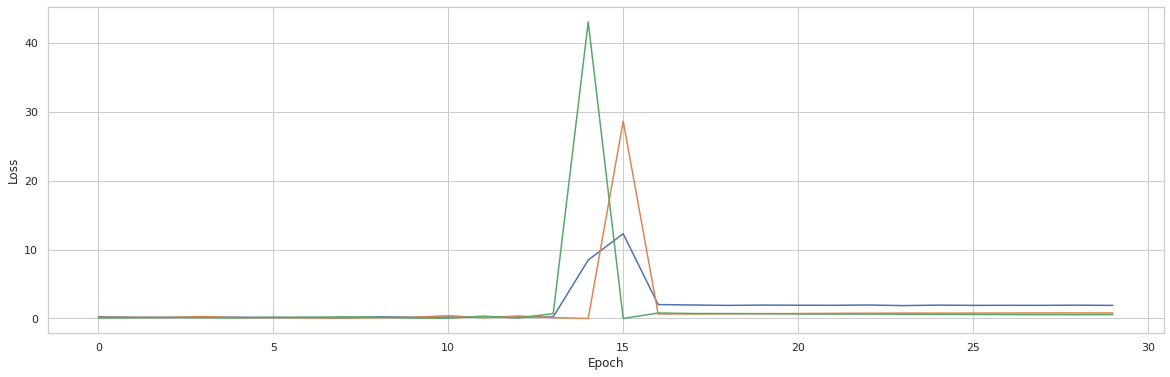

In [36]:
discriminator_source_labels = torch.zeros(BATCH_SIZE, dtype=torch.long).to(DEVICE) # Discriminator label to Photo
discriminator_target_labels = torch.ones(BATCH_SIZE, dtype=torch.long).to(DEVICE) # Discriminator label to Art Painting
discriminator_labels = torch.cat([discriminator_source_labels, discriminator_target_labels], dim=0)
LAMBDA=0.5
already_recomputed_short_discriminator_target_labels = False

# By default, everything is loaded to cpu
dann = dann.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
cudnn.benchmark # Calling this optimizes runtime
current_step = 0

classifier_losses = []
discriminator_source_losses = []
discriminator_target_losses = []
titles = [
          "Classifier losses",
          "Discriminator source losses",
          "Discriminator target losses"
]

# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
    print("Epoch " + str(epoch+1))
    for index, (source_images, labels) in enumerate(dataloader_source):

      dann.train()

      target_images, target_set = sample_target(current_step, BATCH_SIZE)

      source = source_images.to(DEVICE)
      target = target_images.to(DEVICE)
      labels = labels.to(DEVICE)

      optimizer.zero_grad()

      classifier_output = dann(source)
      classifier_loss = loss_classifier(classifier_output, labels)
      classifier_loss.backward()

      print("Classifier loss: ", str(classifier_loss.item()))

      discriminator_output_source = dann(source, LAMBDA)
      discriminator_loss_source = loss_discriminator(discriminator_output_source, discriminator_source_labels)
      discriminator_loss_source.backward()

      print("Discriminator (source) loss: ", str(discriminator_loss_source.item()))

      discriminator_output_target = dann(target, LAMBDA)
      
      if BATCH_SIZE != len(discriminator_output_target):
        if already_recomputed_short_discriminator_target_labels == False:
          already_recomputed_discriminator_target_labels = True
          short_discriminator_target_labels = torch.zeros(len(discriminator_output_target), dtype = torch.long).to(DEVICE)
        discriminator_loss_target = loss_discriminator(discriminator_output_target, short_discriminator_target_labels)
      else:
        discriminator_loss_target = loss_discriminator(discriminator_output_target, discriminator_target_labels)
      
      discriminator_loss_target.backward()

      print("Discriminator (target) loss: ", str(discriminator_loss_target.item()))

      optimizer.step()

    classifier_losses.append( (epoch, classifier_loss.item()) )
    discriminator_source_losses.append( (epoch, discriminator_loss_source.item()) )
    discriminator_target_losses.append( (epoch, discriminator_loss_target.item()) )

    scheduler.step() 

output.clear()
plot_losses(classifier_losses, discriminator_source_losses, discriminator_target_losses, titles)


In [0]:
def plot_losses(classifier_losses, discriminator_source_losses, discriminator_target_losses, titles):
  classifier_loss_df = pd.DataFrame(classifier_losses)
  classifier_loss_df = classifier_loss_df.astype(float)
  classifier_loss_df.columns=['Epoch','Loss']

  discriminator_source_loss_df = pd.DataFrame(discriminator_source_losses)
  discriminator_source_loss_df = discriminator_source_loss_df.astype(float)
  discriminator_source_loss_df.columns=['Epoch','Loss']

  discriminator_target_loss_df = pd.DataFrame(discriminator_target_losses)
  discriminator_target_loss_df = discriminator_target_loss_df.astype(float)
  discriminator_target_loss_df.columns=['Epoch','Loss']

  plt.figure()  
  sns.set(style = "whitegrid")
  fig, ax = plt.subplots(figsize=(20, 6))

  sns.lineplot(x='Epoch',y='Loss',data=classifier_loss_df, markers=True, dashes=False,  ax = ax)
  # .set_title(titles[0])
  sns.lineplot(x='Epoch',y='Loss',data=discriminator_source_loss_df, markers=True, dashes=False,  ax = ax)
  # .set_title(titles[1])
  sns.lineplot(x='Epoch',y='Loss',data=discriminator_target_loss_df, markers=True, dashes=False,  ax = ax)
  # .set_title(titles[2])

  return